Epoch [1/10], Train Loss: 3.0590, Train Accuracy: 17.24%, Val Loss: 2.2295, Val Accuracy: 76.89%
Epoch [2/10], Train Loss: 1.9397, Train Accuracy: 56.86%, Val Loss: 1.2252, Val Accuracy: 88.89%
Epoch [3/10], Train Loss: 1.1780, Train Accuracy: 75.33%, Val Loss: 0.7112, Val Accuracy: 94.22%
Epoch [4/10], Train Loss: 0.8670, Train Accuracy: 80.57%, Val Loss: 0.4963, Val Accuracy: 94.67%
Epoch [5/10], Train Loss: 0.6636, Train Accuracy: 85.52%, Val Loss: 0.3865, Val Accuracy: 96.44%
Epoch [6/10], Train Loss: 0.5550, Train Accuracy: 89.24%, Val Loss: 0.3558, Val Accuracy: 97.78%
Epoch [7/10], Train Loss: 0.4826, Train Accuracy: 91.24%, Val Loss: 0.2453, Val Accuracy: 98.22%
Epoch [8/10], Train Loss: 0.4144, Train Accuracy: 92.48%, Val Loss: 0.2265, Val Accuracy: 98.67%
Epoch [9/10], Train Loss: 0.3685, Train Accuracy: 94.00%, Val Loss: 0.1746, Val Accuracy: 99.56%
Epoch [10/10], Train Loss: 0.3554, Train Accuracy: 94.76%, Val Loss: 0.1826, Val Accuracy: 96.89%


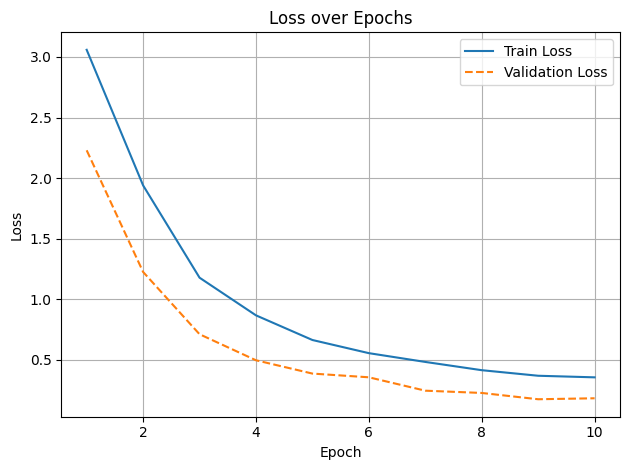

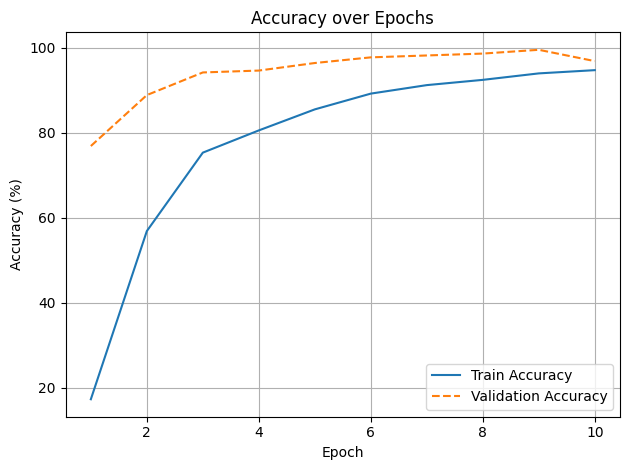


Test Accuracy: 96.89%

Test Classification Report:
                               precision    recall  f1-score   support

                     Anusshar       1.00      1.00      1.00        11
                       Ba Bha       1.00      1.00      1.00         6
     Ba-y Ra Da-y Ra Dha-y Ra       0.86      1.00      0.92         6
                     Bisharga       1.00      1.00      1.00         7
             Borgio JaAnta Ja       1.00      1.00      1.00         9
                           Ca       1.00      0.62      0.76        13
                          Cha       0.56      1.00      0.71         5
                Chandra Bindu       1.00      1.00      1.00         5
                           Da       1.00      1.00      1.00         4
                          Dha       1.00      1.00      1.00         5
                           Ga       1.00      1.00      1.00         3
                          Gha       1.00      1.00      1.00         5
                        

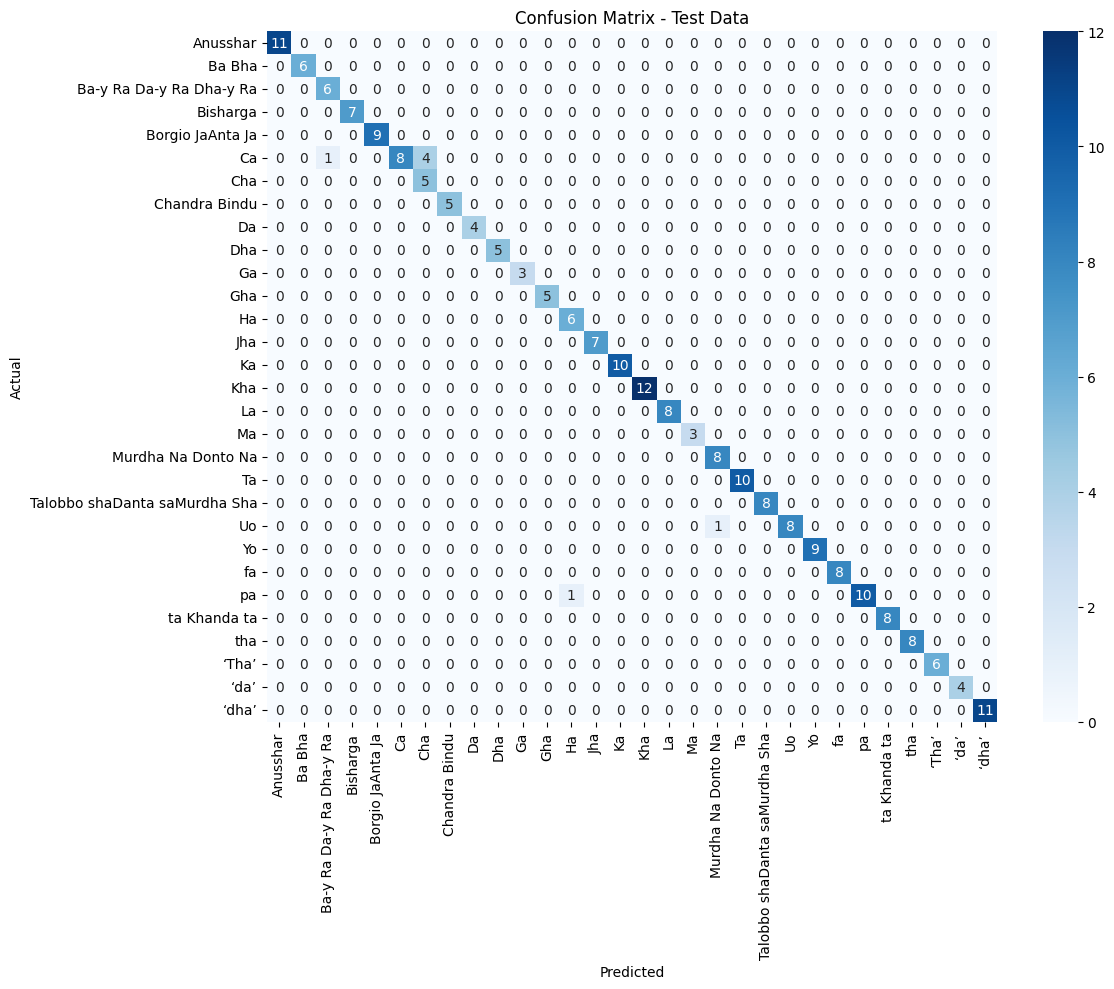


Validation Accuracy: 97.78%

Validation Classification Report:
                               precision    recall  f1-score   support

                     Anusshar       1.00      1.00      1.00         6
                       Ba Bha       1.00      1.00      1.00         7
     Ba-y Ra Da-y Ra Dha-y Ra       1.00      1.00      1.00         7
                     Bisharga       1.00      1.00      1.00         7
             Borgio JaAnta Ja       1.00      1.00      1.00        13
                           Ca       1.00      0.50      0.67         4
                          Cha       0.80      1.00      0.89         8
                Chandra Bindu       1.00      1.00      1.00         7
                           Da       0.92      1.00      0.96        12
                          Dha       1.00      1.00      1.00        11
                           Ga       1.00      1.00      1.00         4
                          Gha       1.00      1.00      1.00         8
            

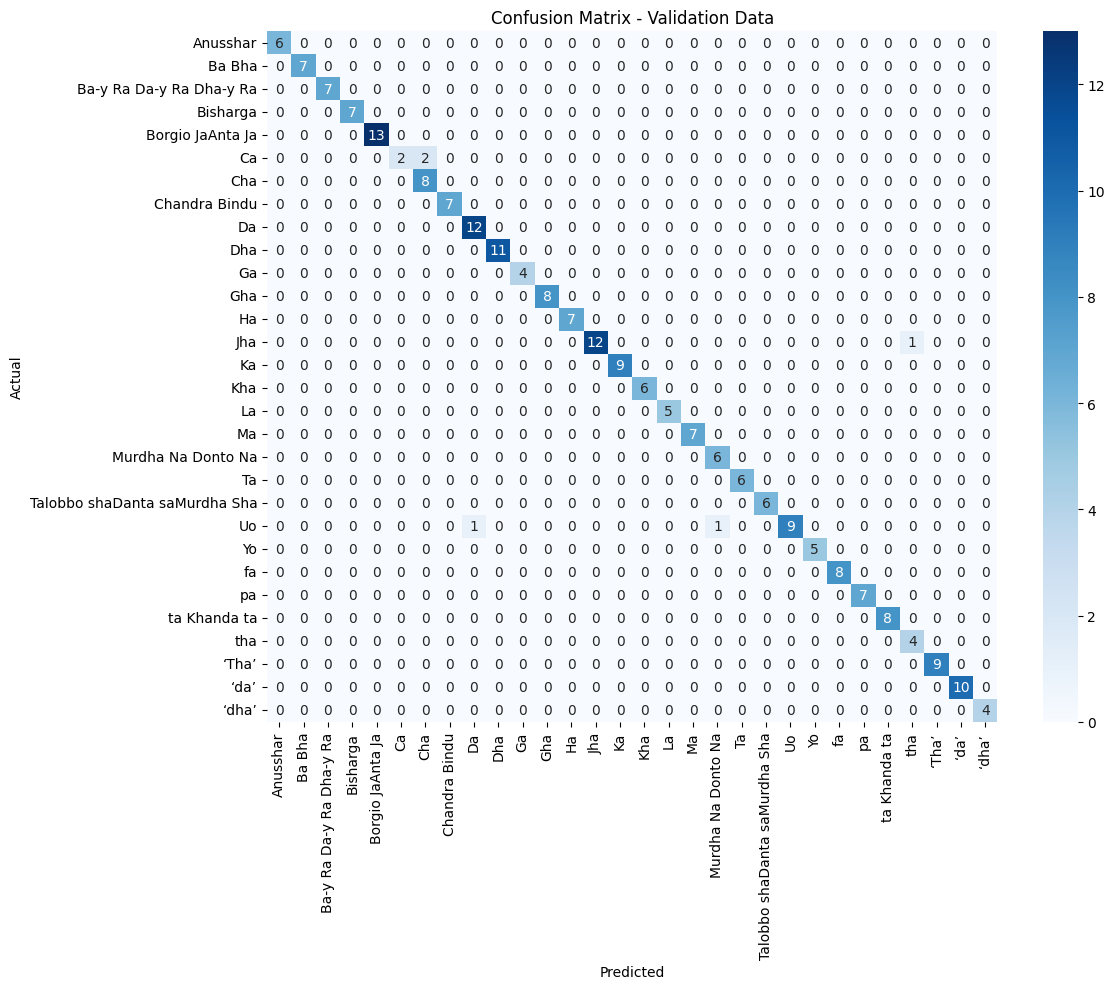

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "C:\\Users\\AJ\\PycharmProjects\\PythonProject\\USLD"  # Path to the USLD folder

#  Transform with augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Augment data by flipping images
    transforms.RandomRotation(15),  # Random rotation of images
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

#  Split dataset (70% train, 15% val, 15% test)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

#  Dataloaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

#  Load ResNet50 and add Dropout
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Load pre-trained weights
for param in model.parameters():
    param.requires_grad = False  # freeze base

# Adding Dropout layer and L2 regularization to prevent overfitting
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Dropout with 50% probability
    nn.Linear(512, num_classes)
)
model = model.to(device)

#  Loss & Optimizer with L2 Regularization (Weight Decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization added

#  Track loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

#  Early stopping variables
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping if no improvement
patience_counter = 0

#  Training Loop with Early Stopping
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loss and accuracy
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

#  Save model
torch.save(model.state_dict(), "bdsl_resnet50_with_dropout_early_stopping.pth")

#  Plot loss and validation curve
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Plot accuracy curve
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Test Accuracy & Classification
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"\nTest Accuracy: {acc:.2f}%\n")

#  Classification Report for Test Data
print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#  Confusion Matrix for Test Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.tight_layout()
plt.show()

#  Validation Accuracy & Classification
model.eval()
y_true_val, y_pred_val = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_val.extend(labels.cpu().numpy())
        y_pred_val.extend(predicted.cpu().numpy())

val_acc = 100 * np.sum(np.array(y_true_val) == np.array(y_pred_val)) / len(y_true_val)
print(f"\nValidation Accuracy: {val_acc:.2f}%\n")

#  Classification Report for Validation Data
print("Validation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=class_names))

#  Confusion Matrix for Validation Data
cm_val = confusion_matrix(y_true_val, y_pred_val)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Data")
plt.tight_layout()
plt.show()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\AJ/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch [1/10], Train Loss: 3.1136, Train Accuracy: 16.19%, Val Loss: 2.4712, Val Accuracy: 44.89%
Epoch [2/10], Train Loss: 2.1431, Train Accuracy: 46.95%, Val Loss: 1.4506, Val Accuracy: 75.56%
Epoch [3/10], Train Loss: 1.5153, Train Accuracy: 62.10%, Val Loss: 1.0359, Val Accuracy: 82.22%
Epoch [4/10], Train Loss: 1.0995, Train Accuracy: 73.43%, Val Loss: 0.8286, Val Accuracy: 81.33%
Epoch [5/10], Train Loss: 1.0089, Train Accuracy: 74.19%, Val Loss: 0.6272, Val Accuracy: 89.33%
Epoch [6/10], Train Loss: 0.8674, Train Accuracy: 78.00%, Val Loss: 0.5680, Val Accuracy: 90.22%
Epoch [7/10], Train Loss: 0.7894, Train Accuracy: 80.19%, Val Loss: 0.6184, Val Accuracy: 87.11%
Epoch [8/10], Train Loss: 0.7120, Train Accuracy: 82.29%, Val Loss: 0.4337, Val Accuracy: 90.67%
Epoch [9/10], Train Loss: 0.6671, Train Accuracy: 81.71%, Val Loss: 0.5098, Val Accuracy: 87.11%
Epoch [10/10], Train Loss: 0.6811, Train Accuracy: 82.29%, Val Loss: 0.4401, Val Accuracy: 90.22%


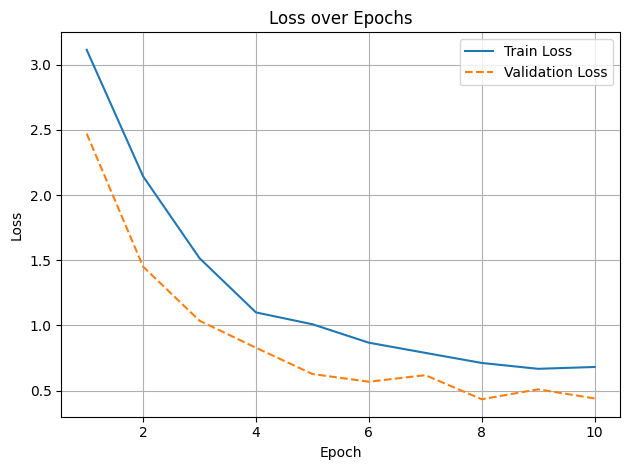

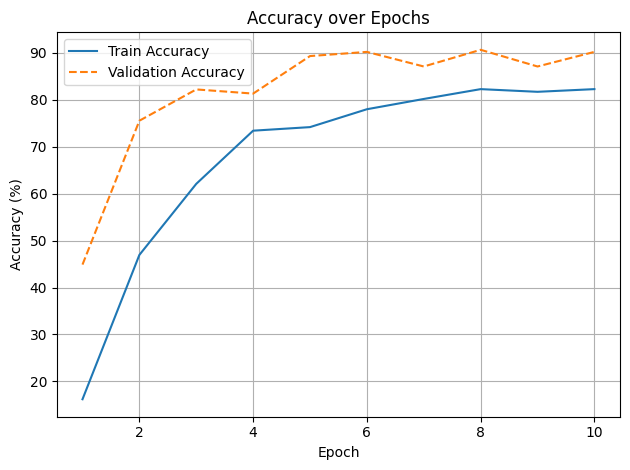


Test Accuracy: 93.33%

Test Classification Report:
                               precision    recall  f1-score   support

                     Anusshar       1.00      0.75      0.86         8
                       Ba Bha       1.00      1.00      1.00         7
     Ba-y Ra Da-y Ra Dha-y Ra       1.00      0.83      0.91         6
                     Bisharga       1.00      1.00      1.00         5
             Borgio JaAnta Ja       1.00      1.00      1.00         4
                           Ca       0.83      1.00      0.91         5
                          Cha       0.92      1.00      0.96        11
                Chandra Bindu       1.00      1.00      1.00         4
                           Da       1.00      1.00      1.00         9
                          Dha       1.00      0.86      0.92         7
                           Ga       0.78      0.88      0.82         8
                          Gha       1.00      1.00      1.00        11
                        

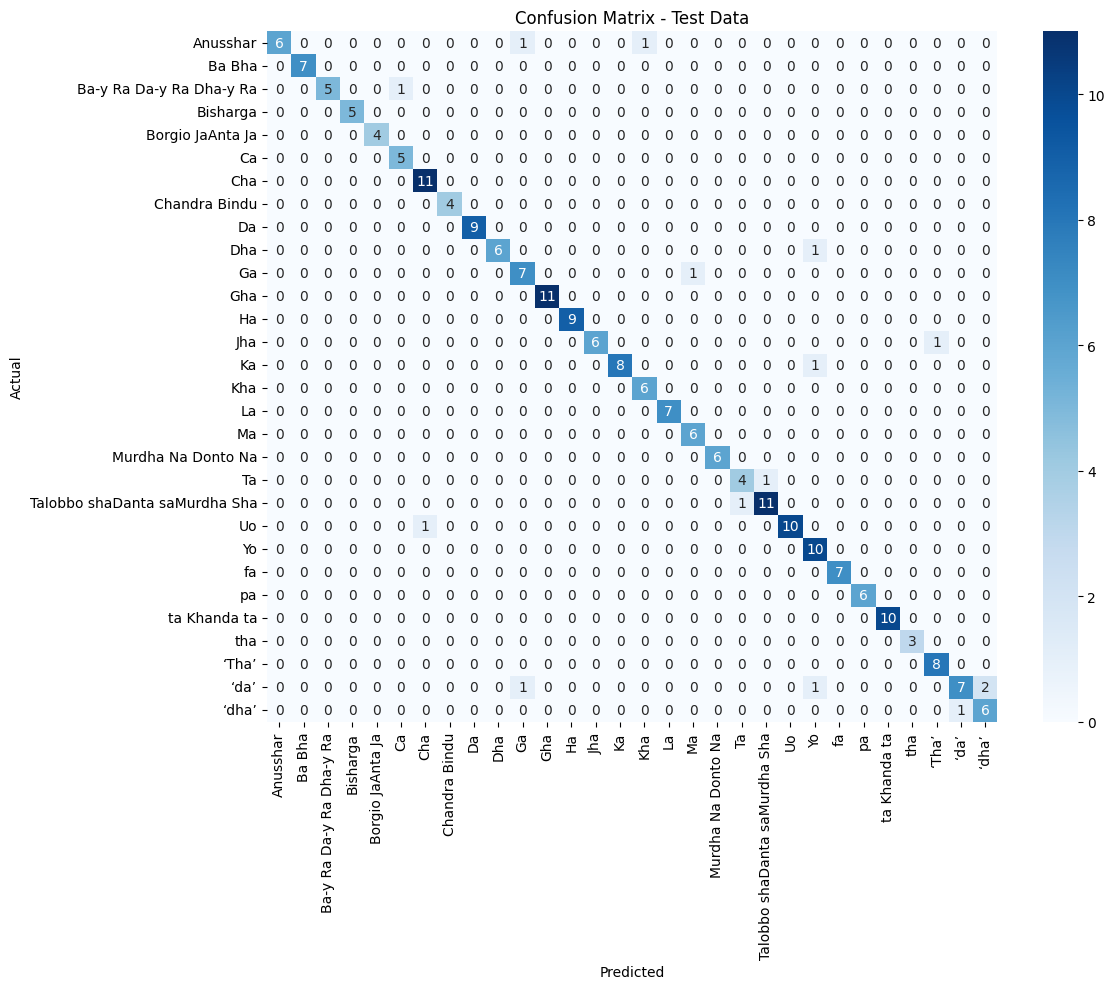


Validation Accuracy: 91.11%

Validation Classification Report:
                               precision    recall  f1-score   support

                     Anusshar       0.86      0.86      0.86         7
                       Ba Bha       1.00      1.00      1.00         7
     Ba-y Ra Da-y Ra Dha-y Ra       1.00      0.71      0.83         7
                     Bisharga       1.00      1.00      1.00        12
             Borgio JaAnta Ja       1.00      1.00      1.00         9
                           Ca       0.88      1.00      0.93         7
                          Cha       0.86      1.00      0.92         6
                Chandra Bindu       1.00      1.00      1.00        12
                           Da       1.00      0.83      0.91         6
                          Dha       1.00      0.80      0.89        10
                           Ga       1.00      0.70      0.82        10
                          Gha       0.89      1.00      0.94         8
            

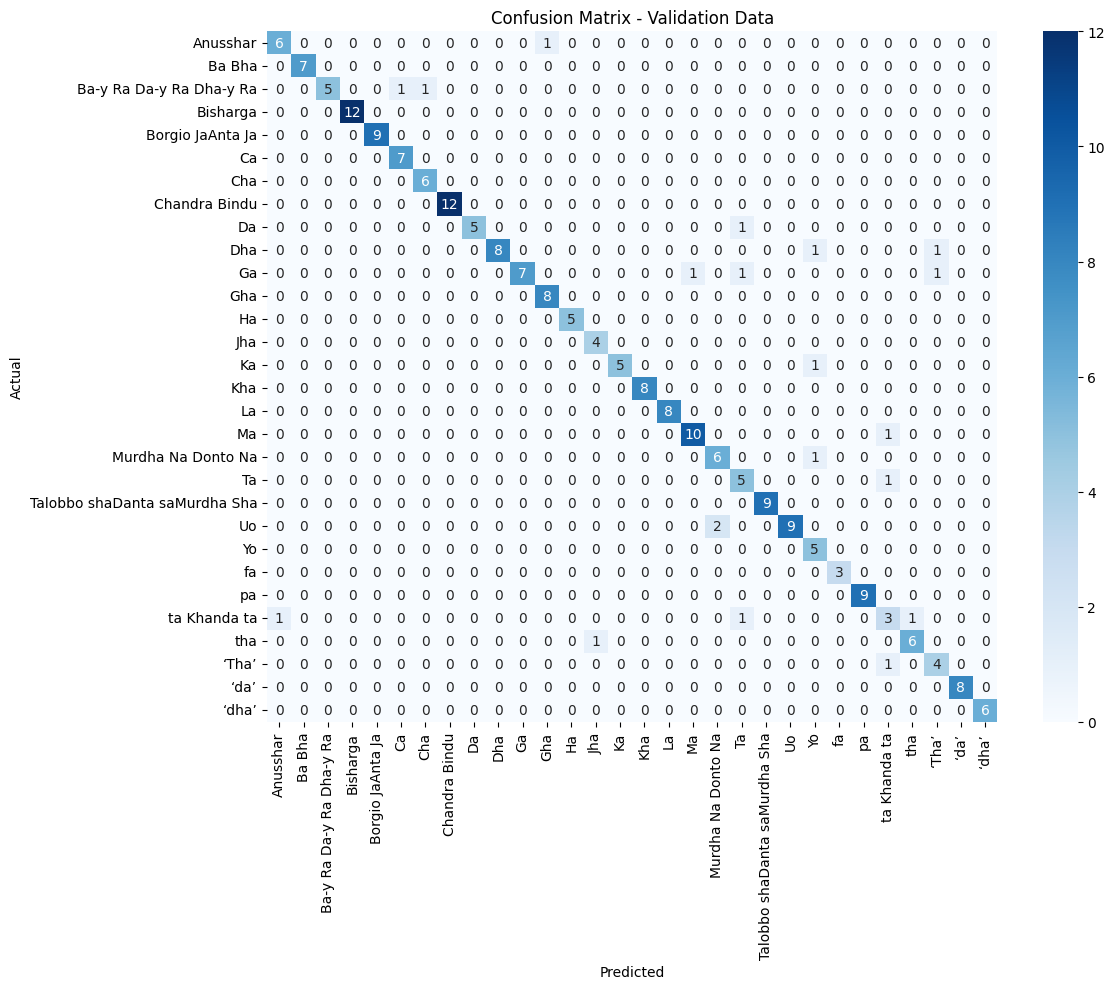

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from sklearn.model_selection import KFold

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the dataset
dataset_path = "C:\\Users\\AJ\\PycharmProjects\\PythonProject\\USLD"

#  Data Transformations with Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(15),  # Random rotation for more variance
    transforms.RandomResizedCrop(224),  # Randomly resize and crop
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize images
])

# Load the full dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

# Split dataset (70% train, 15% val, 15% test)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

# Dataloader for training, validation, and testing
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# Load a smaller ResNet model (e.g., ResNet18 to avoid overfitting)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Using a smaller model

# Freeze the base layers and only train the classifier
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Apply dropout to prevent overfitting
    nn.Linear(512, num_classes)
)

model = model.to(device)

# Loss function and optimizer with L2 Regularization (Weight Decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization

# Training with Early Stopping
best_val_loss = float('inf')
patience = 3  # Stop if validation loss doesn't improve for 3 epochs
patience_counter = 0

# Tracking loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Early stopping variables
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loss and accuracy
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "final_resnet_model.pth")

# Plot Loss Curve
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy Curve
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test Accuracy & Classification
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"\nTest Accuracy: {acc:.2f}%\n")

# Classification Report for Test Data
print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix for Test Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.tight_layout()
plt.show()

# Validation Accuracy & Classification
model.eval()
y_true_val, y_pred_val = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_val.extend(labels.cpu().numpy())
        y_pred_val.extend(predicted.cpu().numpy())

val_acc = 100 * np.sum(np.array(y_true_val) == np.array(y_pred_val)) / len(y_true_val)
print(f"\nValidation Accuracy: {val_acc:.2f}%\n")

# Classification Report for Validation Data
print("Validation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=class_names))

# Confusion Matrix for Validation Data
cm_val = confusion_matrix(y_true_val, y_pred_val)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Data")
plt.tight_layout()
plt.show()
